# Monthly Maintainers

###  Draft RPGF3 List ✨

In [1]:
import json
import pandas as pd

from scripts.oso_db import execute_query
from scripts.eas_lists import OsoData, listify, create_eas_json

# Prep

In [2]:
# settings

DATA_DIR  = "data/RPGF3/"
DATA_PATH = DATA_DIR + "2023-11_06_RPGF3_cleaned_applicant_data.json"

LIST_NAME = "MonthlyMaintainers"
LINK_BASE = "https://github.com/opensource-observer/insights/blob/main/notebooks/"
FILENAME  = "2023-11-04_MonthlyMaintainers.ipynb"
LIST_LINK = LINK_BASE + FILENAME

LIST_DESC = " ".join([
                "This list awards tokens based on the number of man-months a project appears to be maintained.",
                "First, we try to identify code maintainers as non-bot contributors who merge PRs or close issues.",
                "Then, we filter on contributors who perform more than 10 such actions in a given month across all",
                "repos owned by a project. Finally, we calculate the number of man-months this represents for a project."
                "The list awards OP Tokens pro-rata to that project based on our pseudo-mythical man-month calcs.",
            ])
LIST_CATS = [
            #'COLLECTIVE_GOVERNANCE',
            'DEVELOPER_ECOSYSTEM', 
            'END_USER_EXPERIENCE_AND_ADOPTION', 
            'OP_STACK'
            ]

AWARD_AMT = 2 * 10e6

JSON_PATH = DATA_DIR + "lists/" + LIST_NAME + ".json"

In [3]:
# ingest data

oso = OsoData(DATA_PATH)
slugs = oso.get_project_slugs()
slugs_to_ids = oso.map_slugs_to_ids()
#duplicates = oso.check_duplicate_slugs()

Loaded 311 OSS projects from data/RPGF3/2023-11_06_RPGF3_cleaned_applicant_data.json.
Identified 311 unique slugs.


# Get the data to power the list

In [4]:
# run query (may take a few minutes)

slugs_list = "','".join(slugs)
min_days = 10

query = f"""
    WITH Maintainers AS (
        SELECT 
            p."slug" AS "slug",
            e."fromId" AS "fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM-01') AS "bucketMonthly",
            COUNT(DISTINCT e."time") >= {min_days} AS "maintainer"
        FROM 
            event e
        JOIN 
            project_artifacts_artifact paa ON e."toId" = paa."artifactId"
        JOIN 
            project p ON paa."projectId" = p.id        
        WHERE
            e."typeId" IN (
                3, -- PULL_REQUEST_MERGED
                -- 17, -- PULL_REQUEST_APPROVED
                6 -- ISSUE_CLOSED
            )
            AND p.slug IN ('{slugs_list}')
        GROUP BY
            p."slug",
            e."fromId",
            TO_CHAR(DATE_TRUNC('MONTH', e."time"), 'YYYY-MM-01')
    )
    , MonthlyMaintainers AS (
        SELECT
            "slug",
            "bucketMonthly",
            COUNT(DISTINCT "fromId") as "manMonths"
        FROM 
            Maintainers
        GROUP BY
            "slug",
            "bucketMonthly"
    )
    SELECT 
        "slug",
        CAST(SUM("manMonths") AS INTEGER) AS "totalManMonths"
    FROM
        MonthlyMaintainers
    GROUP BY
        "slug";

"""
results = execute_query(query, col_names=False)

In [5]:
# transform query results

maintainers = {project: mm for (project,mm) in results}

# Generate the list

In [6]:
named_list = listify(maintainers, AWARD_AMT)
rpgf_list = {slugs_to_ids[k]:v for k,v in named_list.items()}

<AxesSubplot:>

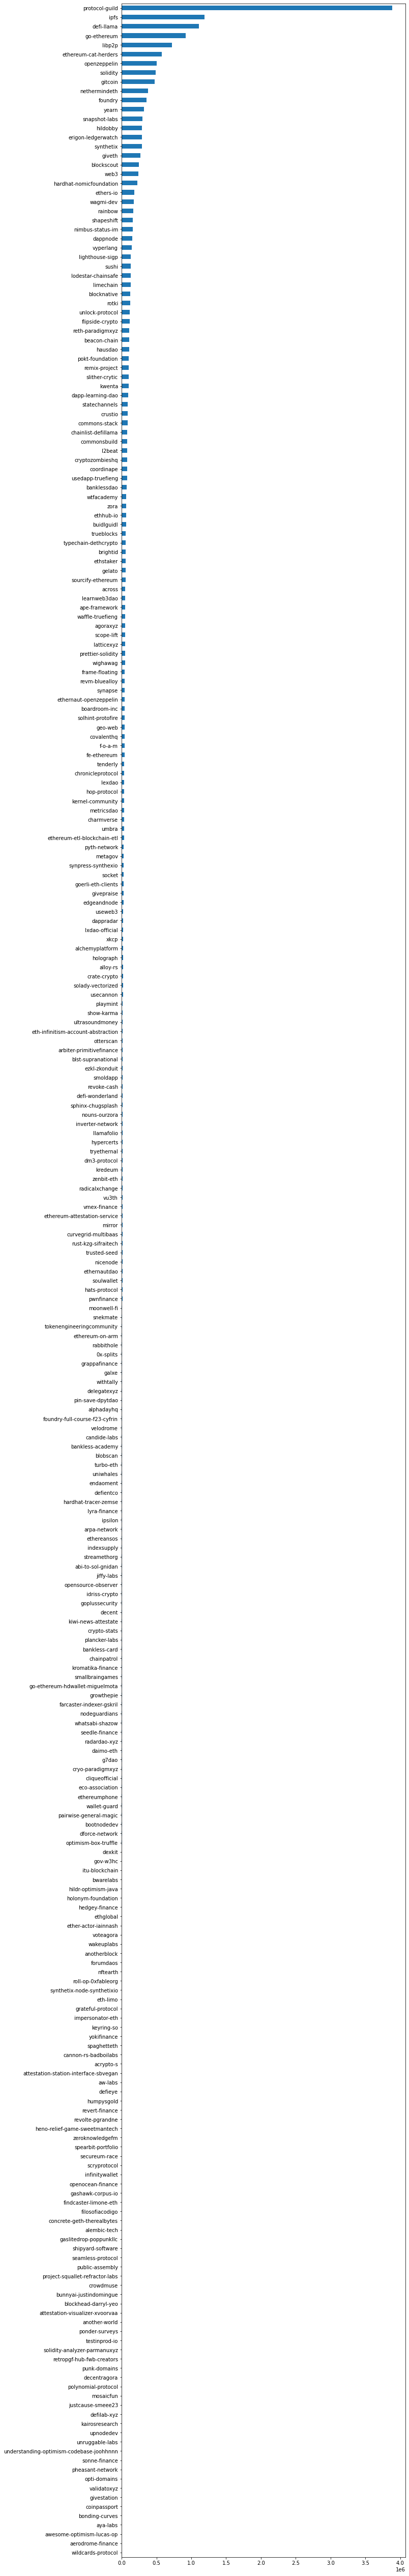

In [7]:
series = pd.Series(named_list).sort_values()
series = series[series>0]
series.plot(kind='barh', figsize=(10,len(rpgf_list)/3))

In [8]:
eas_metadata = create_eas_json(rpgf_list, LIST_NAME, LIST_LINK, LIST_DESC, LIST_CATS)

In [9]:
with open(JSON_PATH, "w") as f:
    json.dump(eas_metadata, f, indent=4)